<a href="https://colab.research.google.com/github/Jorgecardetegit/NLP/blob/main/RNN_vs_LSTM_vs_GRU_vs_CNN_(1D)_vs_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RNN vs LSTM vs GRU vs CNN (1D) vs Transformer**

# 1. Importing libraries and installing dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

from numpy import random

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve

In [ ]:
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

from tensorboard.plugins import projector

In [ ]:
import datetime
import pathlib
import io
import os
import re
import string
import time
import gensim.downloader as api

In [ ]:
from google.colab import drive
from google.colab import files

# 2. Load dataset

In [ ]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

# 3. Basic EDA

In [ ]:
for review,label in val_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

# 4. Preprocessing

In [ ]:
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300

### 4.1 Standardization

In [ ]:
def standardization(input_data):

    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

#### **Standardization Example:**

In [ ]:
standardization(tf.constant("In the movie?, man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion'>

### 4.2 Vectorization

In [ ]:
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

def vectorizer(review,label):
    return vectorize_layer(review),label

In [ ]:
training_data=train_ds.map(lambda x,y:x)
vectorize_layer.adapt(training_data)

In [ ]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

### 4.3 Batching and Prefetching

In [ ]:
BATCH_SIZE = 64

train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# 5. Models

In [ ]:
class train_model():
  loss = tf.keras.losses.BinaryCrossentropy()
  optimizer = tf.keras.optimizers.Adam(1e-4)
  metrics = "accuracy"

  def __init__(self):

    self.loss = loss
    self.optimizer = optimizer
    self.metrics = metrics

    self.epochs = 10

  def compiler(self, model):
    model.compile(loss = self.loss, optimizer = self.optimizer, metrics = [self.metric])

  def history(self, model, train_dataset, val_dataset):
    model.fit(train_dataset, validation_data = val_dataset, epochs = self.epochs)

  def save_weights(self,model):
    model.save()

  def eval_loss_and_accuracy(self, history)

    plt.figure(figsize=(9, 4))  # Adjust the figure size for better visibility

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('RNN_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('RNN_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

    plt.tight_layout()
    plt.show()

  def test(self, test_dataset):

    test_dataset=test_ds.map(vectorizer)
    test_dataset=test_dataset.batch(BATCH_SIZE)
    return model.evaluate(train_dataset)


## 5.1 RNN

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,)

Epoch 1/10
391/391 [==============================] - 27s 66ms/step - loss: 0.6948 - accuracy: 0.4997 - val_loss: 0.6941 - val_accuracy: 0.4948
Epoch 2/10
391/391 [==============================] - 25s 65ms/step - loss: 0.6842 - accuracy: 0.5494 - val_loss: 0.6951 - val_accuracy: 0.5018
Epoch 3/10
391/391 [==============================] - 27s 70ms/step - loss: 0.6587 - accuracy: 0.6232 - val_loss: 0.7003 - val_accuracy: 0.5061
Epoch 4/10
391/391 [==============================] - 25s 65ms/step - loss: 0.5967 - accuracy: 0.7228 - val_loss: 0.7089 - val_accuracy: 0.5218
Epoch 5/10
391/391 [==============================] - 26s 67ms/step - loss: 0.5126 - accuracy: 0.7958 - val_loss: 0.7218 - val_accuracy: 0.5305
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.4383 - accuracy: 0.8402 - val_loss: 0.7416 - val_accuracy: 0.5488
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3891 - accuracy: 0.8648 - val_loss: 0.7656 - val_accuracy:

## 5.1.1 Evaluation

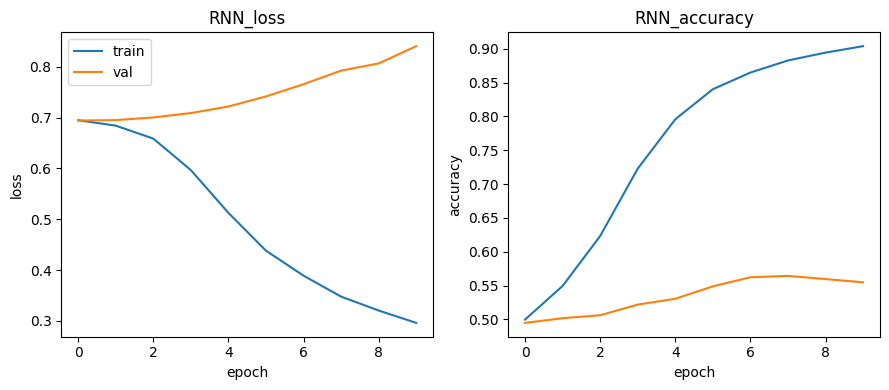

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(9, 4))  # Adjust the figure size for better visibility

# First subplot for loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Second subplot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Display both plots
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
print(model.evaluate(train_dataset))

391/391 [==============================] - 8s 21ms/step - loss: 0.3338 - accuracy: 0.8793
[0.33378535509109497, 0.8793200254440308]


### 5.2 LSTM

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,)

Epoch 1/10
391/391 [==============================] - 290s 720ms/step - loss: 0.6383 - accuracy: 0.6042 - val_loss: 0.4207 - val_accuracy: 0.8171
Epoch 2/10
391/391 [==============================] - 273s 698ms/step - loss: 0.3454 - accuracy: 0.8598 - val_loss: 0.3356 - val_accuracy: 0.8604
Epoch 3/10
391/391 [==============================] - 236s 603ms/step - loss: 0.2547 - accuracy: 0.9067 - val_loss: 0.3518 - val_accuracy: 0.8627
Epoch 4/10
391/391 [==============================] - 235s 601ms/step - loss: 0.2112 - accuracy: 0.9282 - val_loss: 0.4009 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 202s 516ms/step - loss: 0.1897 - accuracy: 0.9365 - val_loss: 0.3822 - val_accuracy: 0.8618
Epoch 6/10
391/391 [==============================] - 193s 494ms/step - loss: 0.1618 - accuracy: 0.9465 - val_loss: 0.4222 - val_accuracy: 0.8590
Epoch 7/10
391/391 [==============================] - 198s 507ms/step - loss: 0.1351 - accuracy: 0.9595 - val_loss: 0.5081 -

### 5.2.1 Evaluation

In [ ]:
# Set up the figure and axis
plt.figure(figsize=(9, 4))  # Adjust the figure size for better visibility

# First subplot for loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# Second subplot for accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

# Display both plots
plt.tight_layout()  # Adjust the layout for better spacing
plt.show()

In [ ]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
print(model.evaluate(test_dataset))

### 5.3 GRU (MultiLayer and Bidirectional)

In [ ]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### 5.4 CNN